In [100]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import optuna
import joblib
import os
from scipy import stats

In [101]:
import pandas as pd

# Cargar datos históricos de criptomonedas
df = pd.read_csv(r"/home/zhgx/Curso/3-Machine_Learning/ML_project/src/data/crypto_historical_365days.csv")
df.head()

,coin_id,coin_name,symbol,market_cap_rank,timestamp,date,price,market_cap,volume,daily_return,price_ma7,price_ma30,volatility_7d,cumulative_return,month
0,aave,Aave,AAVE,46,2024-12-04 00:00:00,2024-12-04,241.886714,3.633154e+09,1.181708e+09,NaN,241.886714,241.886714,NaN,NaN,2024-12
1,aave,Aave,AAVE,46,2024-12-05 00:00:00,2024-12-05,255.966610,3.841768e+09,1.191179e+09,5.820864,248.926662,248.926662,NaN,5.820864,2024-12
2,aave,Aave,AAVE,46,2024-12-06 00:00:00,2024-12-06,248.589404,3.725870e+09,8.706666e+08,-2.882097,248.814243,248.814243,6.153922,2.771004,2024-12
3,aave,Aave,AAVE,46,2024-12-07 00:00:00,2024-12-07,281.755167,4.226339e+09,1.120551e+09,13.341583,257.049474,257.049474,8.119016,16.482283,2024-12
4,aave,Aave,AAVE,46,2024-12-08 00:00:00,2024-12-08,282.398618,4.241226e+09,6.553344e+08,0.228372,262.119303,262.119303,7.120498,16.748297,2024-12


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33364 entries, 0 to 33363
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coin_id            33364 non-null  object 
 1   coin_name          33364 non-null  object 
 2   symbol             33364 non-null  object 
 3   market_cap_rank    33364 non-null  int64  
 4   timestamp          33364 non-null  object 
 5   date               33364 non-null  object 
 6   price              33364 non-null  float64
 7   market_cap         33364 non-null  float64
 8   volume             33364 non-null  float64
 9   daily_return       33264 non-null  float64
 10  price_ma7          33364 non-null  float64
 11  price_ma30         33364 non-null  float64
 12  volatility_7d      33164 non-null  float64
 13  cumulative_return  33264 non-null  float64
 14  month              33364 non-null  object 
dtypes: float64(8), int64(1), object(6)
memory usage: 3.8+ MB


In [103]:
print("Primera fecha:", df["date"].min())
print("Última fecha:", df["date"].max())

Primera fecha: 2024-12-04
Última fecha: 2025-12-03


In [104]:
df["coin_name"].nunique()

100

In [105]:
df["coin_name"].unique()

array(['Aave', 'Algorand', 'Aptos', 'Arbitrum', 'Aster', 'Avalanche',
       'BFUSD', 'Binance Bridged USDC (BNB Smart Chain)',
       'Binance Bridged USDT (BNB Smart Chain)', 'Binance-Peg WETH',
       'Binance Staked SOL', 'BNB', 'Bitcoin', 'Bitcoin Cash',
       'Bitget Token', 'Bittensor',
       'BlackRock USD Institutional Digital Liquidity Fund', 'Canton',
       'Cardano', 'Chainlink', 'Coinbase Wrapped BTC', 'Cosmos Hub',
       'Cronos', 'Dai', 'Dogecoin', 'Ethena', 'Ethena Staked USDe',
       'Ethena USDe', 'Ethereum', 'Ethereum Classic', 'Falcon USD',
       'Figure Heloc', 'Filecoin', 'Flare', 'Gate', 'Global Dollar',
       'Provenance Blockchain', 'Circle USYC', 'Hedera', 'HTX DAO',
       'Hyperliquid', 'Function FBTC', 'Internet Computer',
       'Jito Staked SOL', 'Jupiter Perpetuals Liquidity Provider Token',
       'Kaspa', 'Kelp DAO Restaked ETH', 'KuCoin', 'LEO Token',
       'Litecoin', 'Mantle', 'MemeCore', 'Monero', 'NEAR Protocol',
       'Official Trump', '

In [106]:
coin_counts = (
    df["coin_name"]
    .value_counts()
    .rename("n_rows")
    .to_frame()
)

<Axes: title={'center': 'Top criptos por número de observaciones'}, xlabel='coin_name'>

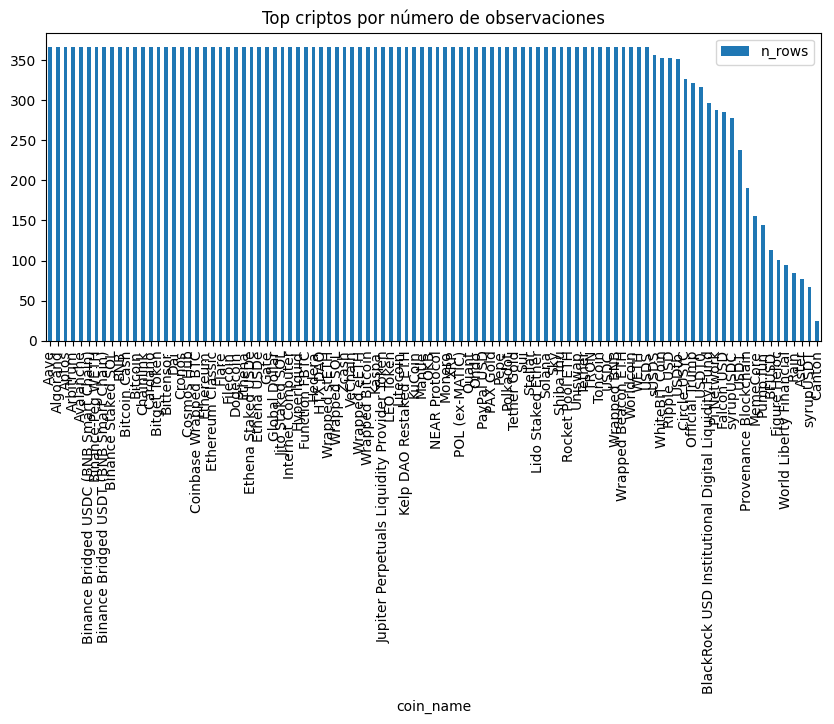

In [107]:
coin_counts.head(100).plot(kind="bar", figsize=(10, 4), title="Top criptos por número de observaciones")

In [108]:
selected_coins = ["Bitcoin", "Ethereum", "BNB", "Solana", "XRP"]

coin_counts.loc[selected_coins]

,n_rows
coin_name,
Bitcoin,366
Ethereum,366
BNB,366
Solana,366
XRP,366


In [109]:
df_sel = df[df["coin_name"].isin(selected_coins)].copy()

## Limpieza de Datos

Realizamos una limpieza inicial: eliminamos valores nulos, columnas innecesarias y configuramos el índice de fecha.

In [110]:
# Limpieza de datos
# Mostrar info inicial
df.info()

# Eliminar filas con NaN
df = df.dropna()

# Eliminar columnas innecesarias
df = df.drop(columns=["coin_id", "symbol", "timestamp", "month", "cumulative_return"])

# Convertir fecha y setear como índice
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()

# Crear target inicial (se redefine después en feature engineering)
df["target"] = (df["daily_return"] > 0).astype(int)

# Eliminar duplicados basados en coin_name y timestamp
df = df.reset_index().drop_duplicates(subset=["coin_name", "date"]).set_index("date").sort_index()
df = df.drop_duplicates()

print("Datos limpios:")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33364 entries, 0 to 33363
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coin_id            33364 non-null  object 
 1   coin_name          33364 non-null  object 
 2   symbol             33364 non-null  object 
 3   market_cap_rank    33364 non-null  int64  
 4   timestamp          33364 non-null  object 
 5   date               33364 non-null  object 
 6   price              33364 non-null  float64
 7   market_cap         33364 non-null  float64
 8   volume             33364 non-null  float64
 9   daily_return       33264 non-null  float64
 10  price_ma7          33364 non-null  float64
 11  price_ma30         33364 non-null  float64
 12  volatility_7d      33164 non-null  float64
 13  cumulative_return  33264 non-null  float64
 14  month              33364 non-null  object 
dtypes: float64(8), int64(1), object(6)
memory usage: 3.8+ MB
Datos limpios

,coin_name,market_cap_rank,price,market_cap,volume,daily_return,price_ma7,price_ma30,volatility_7d,target
date,,,,,,,,,,
2024-12-06,Aave,46,248.589404,3.725870e+09,8.706666e+08,-2.882097,248.814243,248.814243,6.153922,0
2024-12-06,Algorand,86,0.451253,3.746431e+09,9.515104e+08,-5.493970,0.479875,0.479875,0.737902,0
2024-12-06,Kaspa,71,0.159183,4.024276e+09,2.298951e+08,0.130641,0.159135,0.159135,0.212648,1
2024-12-06,Jupiter Perpetuals Liquidity Provider Token,68,4.168467,0.000000e+00,3.188286e+08,0.182674,4.155945,4.155945,0.252943,1
2024-12-06,TRON,9,0.322760,2.781671e+10,7.588938e+09,-1.817492,0.355695,0.355695,13.492761,0


In [111]:
num_cols = df.select_dtypes(include=["float64", "int64"]).columns

## Análisis Exploratorio de Datos (EDA)

Exploramos las correlaciones y distribuciones de las variables para entender el dataset.

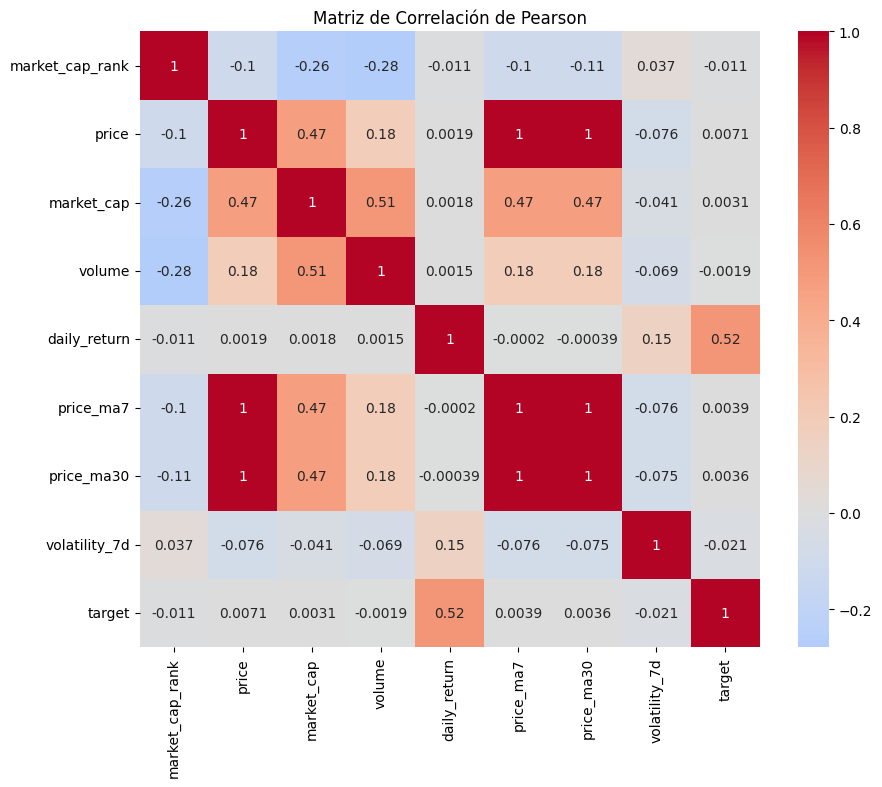

In [112]:
# Matriz de correlación
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0, annot=True)
plt.title("Matriz de Correlación de Pearson")
plt.show()

La matriz de correlación de Pearson muestra fuertes relaciones lineales entre variables directamente derivadas del precio, como el propio precio, el market cap y las medias móviles, lo cual es esperable debido a su definición. En particular, se observa una alta multicolinealidad entre price, price_ma7 y price_ma30, indicando que estas variables contienen información parcialmente redundante.

Por otro lado, la correlación lineal entre la mayoría de las variables y el target es baja, siendo el daily_return la única variable que presenta una correlación moderada, ya que de él se deriva directamente la variable objetivo. Este resultado sugiere que no existen relaciones lineales simples que permitan predecir el target de forma directa, reforzando la necesidad de utilizar modelos de machine learning capaces de combinar múltiples señales y capturar patrones más complejos.

### Análisis Univariado y Detección de Outliers

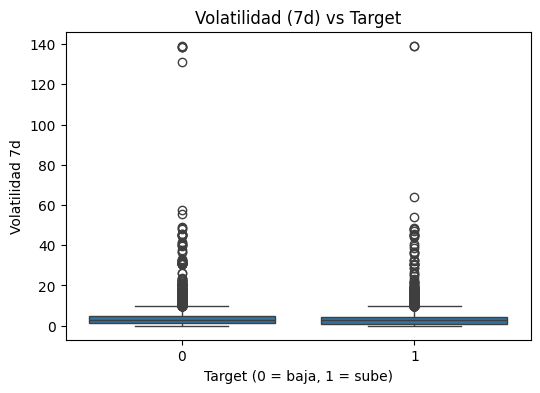

In [113]:
# Boxplot de volatilidad vs target
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="target", y="volatility_7d")
plt.title("Volatilidad (7d) vs Target")
plt.xlabel("Target (0 = baja, 1 = sube)")
plt.ylabel("Volatilidad 7d")
plt.show()

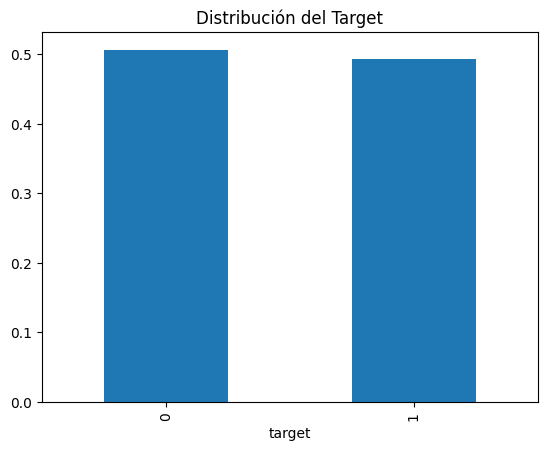

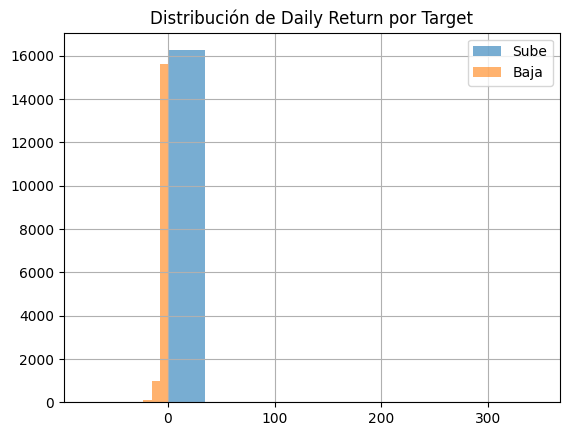

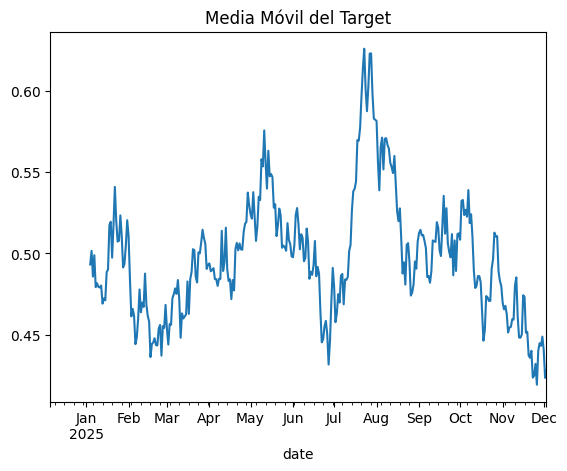

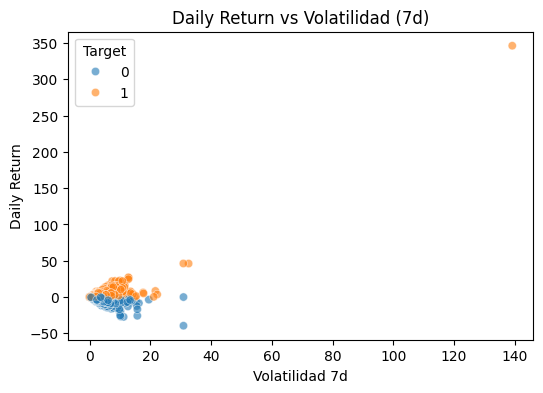

In [114]:
# Distribución del target
df["target"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribución del Target")
plt.show()

# Histogramas de daily_return por target
df[df["target"]==1]["daily_return"].hist(alpha=0.6, label="Sube")
df[df["target"]==0]["daily_return"].hist(alpha=0.6, label="Baja")
plt.legend()
plt.title("Distribución de Daily Return por Target")
plt.show()

# Evolución temporal del target
df.groupby(df.index)["target"].mean().rolling(30).mean().plot()
plt.title("Media Móvil del Target")
plt.show()

# Scatter plot
plt.figure(figsize=(6,4))
sample_size = min(3000, len(df))
sns.scatterplot(
    data=df.sample(sample_size, random_state=42),
    x="volatility_7d",
    y="daily_return",
    hue="target",
    alpha=0.6
)
plt.title("Daily Return vs Volatilidad (7d)")
plt.xlabel("Volatilidad 7d")
plt.ylabel("Daily Return")
plt.legend(title="Target")
plt.show()

El análisis exploratorio muestra un fuerte solapamiento entre las distribuciones de las variables explicativas para ambos valores del target. Tanto los retornos diarios como la volatilidad a 7 días presentan rangos y dispersiones muy similares en los casos de subida y bajada, con presencia de outliers en ambas clases, un comportamiento habitual en series financieras.

Los gráficos que relacionan variables clave, como daily_return y volatility_7d, evidencian la ausencia de una separación clara entre clases en el espacio de características. No obstante, se observan patrones débiles y no lineales, lo que sugiere que la señal no puede capturarse mediante reglas simples.

La evolución temporal del target revela cambios de régimen y falta de estacionariedad, incrementando la complejidad del problema. En conjunto, estos resultados justifican el planteamiento del problema como una tarea de clasificación supervisada basada en modelos de machine learning, capaces de capturar relaciones no lineales y dependencias temporales.

# Feature engineering

In [125]:
# Ingeniería de características
# Target: predicción del día siguiente
df["future_return"] = (
    df.groupby("coin_name")["price"].shift(-1) / df["price"] - 1
)

df["target"] = (df["future_return"] > 0).astype(int)

df = df.drop(columns=["future_return"]) 

# Lags de precio
for lag in [1, 2, 3, 7]:
    df[f"price_lag_{lag}"] = df.groupby("coin_name")["price"].shift(lag)

# Cambios porcentuales
df["price_change_1d"] = df["price"] / df.groupby("coin_name")["price"].shift(1) - 1
df["price_change_7d"] = df["price"] / df.groupby("coin_name")["price"].shift(7) - 1

# Ratio de medias móviles
df["ma_ratio_7_30"] = df["price_ma7"] / df["price_ma30"]

# Eliminar NAs generados
df = df.dropna()

# Separar features y target
X = df.drop(columns=["target"])
y = df["target"]

# División temporal
# División temporal
df = df.sort_index()

test_days = 1

test_idx = df.index[-test_days:]
train_idx = df.index[:-test_days]

X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]

y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

print("Forma de train:", X_train.shape, "Test:", X_test.shape)

Forma de train: (2865232, 16) Test: (100, 16)


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32270 entries, 2024-12-13 to 2025-12-03
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   coin_name        32270 non-null  object 
 1   market_cap_rank  32270 non-null  int64  
 2   price            32270 non-null  float64
 3   market_cap       32270 non-null  float64
 4   volume           32270 non-null  float64
 5   daily_return     32270 non-null  float64
 6   price_ma7        32270 non-null  float64
 7   price_ma30       32270 non-null  float64
 8   volatility_7d    32270 non-null  float64
 9   target           32270 non-null  int64  
 10  price_lag_1      32270 non-null  float64
 11  price_lag_2      32270 non-null  float64
 12  price_lag_3      32270 non-null  float64
 13  price_lag_7      32270 non-null  float64
 14  price_change_1d  32270 non-null  float64
 15  price_change_7d  32270 non-null  float64
 16  ma_ratio_7_30    32270 non-null  float64


## Modelado

Probamos varios modelos: Regresión Logística como baseline, Random Forest y XGBoost optimizados.

Bitcoin	
Ethereum	
BNB	
Solana	
XRP	

In [126]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np


def train_logreg_baseline(
    df,
    coin_name,
    n_splits=5,
    n_trials=20,
    random_state=42
):
    # -------------------------
    # Filtrar moneda
    # -------------------------
    df_coin = df[df["coin_name"] == coin_name].copy()
    df_coin = df_coin.sort_index()

    X = df_coin.drop(columns=["target", "coin_name"])
    y = df_coin["target"]

    # -------------------------
    # Protección: una sola clase (ej. Tether)
    # -------------------------
    if y.nunique() < 2:
        return {
            "coin": coin_name,
            "model": "LogisticRegression",
            "cv_roc_auc": np.nan,
            "best_params": None
        }

    # -------------------------
    # CV temporal
    # -------------------------
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # -------------------------
    # Optuna objective
    # -------------------------
    def objective(trial):
        C = trial.suggest_float("C", 1e-3, 10, log=True)
        penalty = trial.suggest_categorical("penalty", ["l1", "l2"])

        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver="liblinear",
            max_iter=1000,
            random_state=random_state
        )

        scores = cross_val_score(
            model,
            X,
            y,
            cv=tscv,
            scoring="roc_auc"
        )

        return scores.mean()

    # -------------------------
    # Optuna
    # -------------------------
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    return {
        "coin": coin_name,
        "model": "LogisticRegression",
        "cv_roc_auc": study.best_value,
        "best_params": study.best_params
    }


In [127]:
result = train_logreg_baseline(
    df=df,
    coin_name="Bitcoin",
    n_splits=5,
    n_trials=20
)

print(result)

[I 2026-01-15 15:21:48,306] A new study created in memory with name: no-name-b2912d81-5549-4278-a4a5-50911721a930
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/

{'coin': 'Bitcoin', 'model': 'LogisticRegression', 'cv_roc_auc': 0.5085705042287112, 'best_params': {'C': 0.0011513923985773714, 'penalty': 'l2'}}


In [142]:
result = train_logreg_baseline(
    df=df,
    coin_name="Ethereum",
    n_splits=5,
    n_trials=20
)

print(result)

[I 2026-01-15 15:52:21,345] A new study created in memory with name: no-name-1c99d5db-2f90-4201-a6c3-52c6fe9de987
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/

{'coin': 'Ethereum', 'model': 'LogisticRegression', 'cv_roc_auc': 0.4869046085493453, 'best_params': {'C': 1.350074855680009, 'penalty': 'l2'}}


In [148]:
result = train_logreg_baseline(
    df=df,
    coin_name="BNB",
    n_splits=5,
    n_trials=20
)

print(result)

[I 2026-01-15 16:11:20,786] A new study created in memory with name: no-name-732dbe48-fe34-4876-814a-11f7f46b5544
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/py

{'coin': 'BNB', 'model': 'LogisticRegression', 'cv_roc_auc': 0.5839947878208747, 'best_params': {'C': 8.596698839934886, 'penalty': 'l1'}}


In [144]:
result = train_logreg_baseline(
    df=df,
    coin_name="Solana",
    n_splits=5,
    n_trials=20
)

print(result)

[I 2026-01-15 15:53:49,446] A new study created in memory with name: no-name-2d840ccb-ac5b-4dc1-91ac-089c039d598c
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/

{'coin': 'Solana', 'model': 'LogisticRegression', 'cv_roc_auc': 0.5260013142831401, 'best_params': {'C': 0.022410700920264055, 'penalty': 'l1'}}


In [145]:
result = train_logreg_baseline(
    df=df,
    coin_name="XRP",
    n_splits=5,
    n_trials=20
)

print(result)

[I 2026-01-15 15:53:54,788] A new study created in memory with name: no-name-29fff81f-2c4d-4ff7-8c99-c7d78f003c5b
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/zhgx/.pyenv/versions/3.11.14/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to 

{'coin': 'XRP', 'model': 'LogisticRegression', 'cv_roc_auc': 0.5365573654330771, 'best_params': {'C': 0.15280164032587115, 'penalty': 'l1'}}


In [139]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np

def train_rf_model(
    df,
    coin_name,
    n_splits=5,
    n_trials=30,
    random_state=42
):
    # -------------------------
    # Filtrar moneda
    # -------------------------
    df_coin = df[df["coin_name"] == coin_name].copy()
    df_coin = df_coin.sort_index()

    X = df_coin.drop(columns=["target", "coin_name"])
    y = df_coin["target"]

    # -------------------------
    # Split temporal FINAL (último día)
    # -------------------------
    X_train = X.iloc[:-1]
    y_train = y.iloc[:-1]

    X_test = X.iloc[-1:]
    y_test = y.iloc[-1:]

    # -------------------------
    # CV temporal (solo TRAIN)
    # -------------------------
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # -------------------------
    # Optuna objective
    # -------------------------
    def objective(trial):
        params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced", "balanced_subsample"]),
        "random_state": 42,
        "n_jobs": -1,
        }   

        model = RandomForestClassifier(**params)

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=tscv,
            scoring="roc_auc"
        )

        return scores.mean()

    # -------------------------
    # Optuna
    # -------------------------
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    best_params = study.best_params
    best_cv_score = study.best_value

    # -------------------------
    # Modelo final
    # -------------------------
    best_model = RandomForestClassifier(
        **best_params,
        random_state=random_state,
        n_jobs=-1
    )

    best_model.fit(X_train, y_train)

    # -------------------------
    # ROC AUC TRAIN
    # -------------------------
    y_proba_train = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_proba_train)

    # -------------------------
    # ROC AUC TEST (si se puede)
    # -------------------------
    if y_test.nunique() == 2:
        y_proba_test = best_model.predict_proba(X_test)[:, 1]
        test_roc_auc = roc_auc_score(y_test, y_proba_test)
    else:
        test_roc_auc = np.nan

    return {
        "coin": coin_name,
        "model": "RandomForest",
        "train_roc_auc": train_roc_auc,
        "cv_roc_auc": best_cv_score,
        "test_roc_auc": test_roc_auc,
        "best_params": best_params
    }

In [141]:
result_btc = train_rf_model(
    df=df,
    coin_name="Bitcoin",
    n_splits=5,
    n_trials=30
)

print("Moneda:", result_btc["coin"])
print("Modelo:", result_btc["model"])
print("Train ROC AUC:", result_btc["train_roc_auc"])
print("CV ROC AUC:", result_btc["cv_roc_auc"])
print("Test ROC AUC:", result_btc["test_roc_auc"])
print("Best params:", result_btc["best_params"])

[I 2026-01-15 15:47:08,277] A new study created in memory with name: no-name-87c741fb-f377-484e-a4a2-4b8fb195c927
[I 2026-01-15 15:47:12,913] Trial 0 finished with value: 0.5047769331922558 and parameters: {'n_estimators': 503, 'max_depth': 14, 'min_samples_split': 28, 'min_samples_leaf': 14, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.5047769331922558.
[I 2026-01-15 15:47:23,134] Trial 1 finished with value: 0.5027241879983816 and parameters: {'n_estimators': 836, 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5047769331922558.
[I 2026-01-15 15:47:36,425] Trial 2 finished with value: 0.5052854605072348 and parameters: {'n_estimators': 976, 'max_depth': 7, 'min_samples_split': 24, 'min_samples_leaf': 6, 'max_features': None, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.5052854605072348.
[I 2026-01-15 15:47:45,189] Trial 3 finished

Moneda: Bitcoin
Modelo: RandomForest
Train ROC AUC: 0.8122543352601155
CV ROC AUC: 0.5431848354751581
Test ROC AUC: nan
Best params: {'n_estimators': 210, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 20, 'max_features': 'log2', 'class_weight': 'balanced'}


In [149]:
result_btc = train_rf_model(
    df=df,
    coin_name="Ethereum",
    n_splits=5,
    n_trials=30
)

print("Moneda:", result_btc["coin"])
print("Modelo:", result_btc["model"])
print("Train ROC AUC:", result_btc["train_roc_auc"])
print("CV ROC AUC:", result_btc["cv_roc_auc"])
print("Test ROC AUC:", result_btc["test_roc_auc"])
print("Best params:", result_btc["best_params"])

[I 2026-01-15 16:14:24,572] A new study created in memory with name: no-name-8e6b2026-b797-41ff-ae6c-49358d92ea73
[I 2026-01-15 16:14:30,085] Trial 0 finished with value: 0.5066127712377713 and parameters: {'n_estimators': 289, 'max_depth': 5, 'min_samples_split': 21, 'min_samples_leaf': 20, 'max_features': None, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.5066127712377713.
[I 2026-01-15 16:14:42,216] Trial 1 finished with value: 0.5045157668907669 and parameters: {'n_estimators': 1064, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 16, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5066127712377713.
[I 2026-01-15 16:14:51,306] Trial 2 finished with value: 0.5030937159687159 and parameters: {'n_estimators': 707, 'max_depth': 25, 'min_samples_split': 25, 'min_samples_leaf': 19, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.5066127712377713.
[I 2026-01-15 16:14:56,556

Moneda: Ethereum
Modelo: RandomForest
Train ROC AUC: 0.8260481712756467
CV ROC AUC: 0.5134363575613575
Test ROC AUC: nan
Best params: {'n_estimators': 918, 'max_depth': 8, 'min_samples_split': 24, 'min_samples_leaf': 18, 'max_features': None, 'class_weight': 'balanced_subsample'}


In [150]:
result_btc = train_rf_model(
    df=df,
    coin_name="BNB",
    n_splits=5,
    n_trials=30
)

print("Moneda:", result_btc["coin"])
print("Modelo:", result_btc["model"])
print("Train ROC AUC:", result_btc["train_roc_auc"])
print("CV ROC AUC:", result_btc["cv_roc_auc"])
print("Test ROC AUC:", result_btc["test_roc_auc"])
print("Best params:", result_btc["best_params"])

[I 2026-01-15 16:21:19,864] A new study created in memory with name: no-name-3af7b525-16bc-4072-9ddd-0aaea59cfb82
[I 2026-01-15 16:21:33,012] Trial 0 finished with value: 0.5177734538773232 and parameters: {'n_estimators': 920, 'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.5177734538773232.
[I 2026-01-15 16:21:46,396] Trial 1 finished with value: 0.5314565225415712 and parameters: {'n_estimators': 1090, 'max_depth': 21, 'min_samples_split': 30, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': None}. Best is trial 1 with value: 0.5314565225415712.
[I 2026-01-15 16:21:52,071] Trial 2 finished with value: 0.5239292949893869 and parameters: {'n_estimators': 540, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 1 with value: 0.5314565225415712.
[I 2026-01-15 16:21:58,947] Trial 3 finished w

Moneda: BNB
Modelo: RandomForest
Train ROC AUC: 0.9484010659560294
CV ROC AUC: 0.5314565225415712
Test ROC AUC: nan
Best params: {'n_estimators': 1090, 'max_depth': 21, 'min_samples_split': 30, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': None}


In [152]:
result_btc = train_rf_model(
    df=df,
    coin_name="Solana",
    n_splits=5,
    n_trials=30
)

print("Moneda:", result_btc["coin"])
print("Modelo:", result_btc["model"])
print("Train ROC AUC:", result_btc["train_roc_auc"])
print("CV ROC AUC:", result_btc["cv_roc_auc"])
print("Test ROC AUC:", result_btc["test_roc_auc"])
print("Best params:", result_btc["best_params"])

[I 2026-01-15 16:30:20,881] A new study created in memory with name: no-name-17926da5-3a23-4fb6-b9c1-444947687a61
[I 2026-01-15 16:30:30,496] Trial 0 finished with value: 0.5155456260766116 and parameters: {'n_estimators': 1109, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5155456260766116.
[I 2026-01-15 16:30:36,291] Trial 1 finished with value: 0.5155546840723101 and parameters: {'n_estimators': 614, 'max_depth': 16, 'min_samples_split': 28, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5155546840723101.
[I 2026-01-15 16:30:41,101] Trial 2 finished with value: 0.49088399997335436 and parameters: {'n_estimators': 488, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5155546840723101.
[I 2026-01-15 16:30:45,897] Trial 3 finished wi

Moneda: Solana
Modelo: RandomForest
Train ROC AUC: 0.8746160198183319
CV ROC AUC: 0.5326127690942337
Test ROC AUC: nan
Best params: {'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': None, 'class_weight': None}


In [151]:
result_btc = train_rf_model(
    df=df,
    coin_name="XRP",
    n_splits=5,
    n_trials=30
)

print("Moneda:", result_btc["coin"])
print("Modelo:", result_btc["model"])
print("Train ROC AUC:", result_btc["train_roc_auc"])
print("CV ROC AUC:", result_btc["cv_roc_auc"])
print("Test ROC AUC:", result_btc["test_roc_auc"])
print("Best params:", result_btc["best_params"])

[I 2026-01-15 16:25:46,416] A new study created in memory with name: no-name-a8772ade-cf2a-446d-b0a4-c7cfaff5aff9
[I 2026-01-15 16:26:00,170] Trial 0 finished with value: 0.5250440392940392 and parameters: {'n_estimators': 1119, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.5250440392940392.
[I 2026-01-15 16:26:08,031] Trial 1 finished with value: 0.5399084249084248 and parameters: {'n_estimators': 956, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': None}. Best is trial 1 with value: 0.5399084249084248.
[I 2026-01-15 16:26:18,477] Trial 2 finished with value: 0.5374628704628706 and parameters: {'n_estimators': 1138, 'max_depth': 23, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 1 with value: 0.5399084249084248.
[I 2026-01-15 16:26:23,935] Trial 3 finished wit

Moneda: XRP
Modelo: RandomForest
Train ROC AUC: 0.956850695476922
CV ROC AUC: 0.5507008408258408
Test ROC AUC: nan
Best params: {'n_estimators': 1005, 'max_depth': 29, 'min_samples_split': 29, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': None}


In [153]:
import optuna
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score

In [154]:
def train_xgb_model(
    df,
    coin_name,
    n_splits=5,
    n_trials=30,
    random_state=42
):
    # -------------------------
    # Filtrar moneda
    # -------------------------
    df_coin = df[df["coin_name"] == coin_name].copy()
    df_coin = df_coin.sort_index()

    X = df_coin.drop(columns=["target", "coin_name"])
    y = df_coin["target"]

    # -------------------------
    # Protección: una sola clase
    # -------------------------
    if y.nunique() < 2:
        return {
            "coin": coin_name,
            "model": "XGBoost",
            "cv_roc_auc": np.nan,
            "best_params": None
        }

    # -------------------------
    # Split temporal FINAL (últimos días)
    # -------------------------
    test_days = 1  
    X_train = X.iloc[:-test_days]
    y_train = y.iloc[:-test_days]

    X_test = X.iloc[-test_days:]
    y_test = y.iloc[-test_days:]

    # -------------------------
    # CV temporal (solo TRAIN)
    # -------------------------
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # -------------------------
    # Optuna objective
    # -------------------------
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "max_depth": trial.suggest_int("max_depth", 3, 6),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 10, 50),
            "gamma": trial.suggest_float("gamma", 0.0, 1.0),
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "random_state": random_state,
            "n_jobs": -1,
            "verbosity": 0
        }

        model = XGBClassifier(**params)

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=tscv,
            scoring="roc_auc"
        )

        return scores.mean()

    # -------------------------
    # Optuna
    # -------------------------
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    best_params = study.best_params
    best_cv_score = study.best_value

    # -------------------------
    # Modelo final
    # -------------------------
    best_model = XGBClassifier(
        **best_params,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=random_state,
        n_jobs=-1,
        verbosity=0
    )

    best_model.fit(X_train, y_train)

    # -------------------------
    # ROC AUC TRAIN
    # -------------------------
    y_proba_train = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_proba_train)

    # -------------------------
    # ROC AUC TEST
    # -------------------------
    if y_test.nunique() == 2:
        y_proba_test = best_model.predict_proba(X_test)[:, 1]
        test_roc_auc = roc_auc_score(y_test, y_proba_test)
    else:
        test_roc_auc = np.nan

    return {
        "coin": coin_name,
        "model": "XGBoost",
        "train_roc_auc": train_roc_auc,
        "cv_roc_auc": best_cv_score,
        "test_roc_auc": test_roc_auc,
        "best_params": best_params
    }

In [155]:
res_btc_xgb = train_xgb_model(
    df=df,
    coin_name="Bitcoin",
    n_splits=5,
    n_trials=30
)

print(res_btc_xgb)

[I 2026-01-15 16:36:58,634] A new study created in memory with name: no-name-b4894466-7f4a-4d37-935d-818b03232f46
[I 2026-01-15 16:37:02,342] Trial 0 finished with value: 0.49310411332991977 and parameters: {'n_estimators': 139, 'max_depth': 5, 'learning_rate': 0.01964541433520987, 'subsample': 0.9079157767825945, 'colsample_bytree': 0.9074535495886134, 'min_child_weight': 16, 'gamma': 0.22158477682609712}. Best is trial 0 with value: 0.49310411332991977.
[I 2026-01-15 16:37:02,769] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.084891439794365, 'subsample': 0.6231074462733761, 'colsample_bytree': 0.9672109259922564, 'min_child_weight': 32, 'gamma': 0.415511115427299}. Best is trial 1 with value: 0.5.
[I 2026-01-15 16:37:03,118] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 213, 'max_depth': 6, 'learning_rate': 0.05252110357822687, 'subsample': 0.781119393298095, 'colsample_bytree': 0.6553906538096707, 'min_

{'coin': 'Bitcoin', 'model': 'XGBoost', 'train_roc_auc': 0.7936581337737407, 'cv_roc_auc': 0.528997936352775, 'test_roc_auc': nan, 'best_params': {'n_estimators': 337, 'max_depth': 5, 'learning_rate': 0.04088604828134503, 'subsample': 0.9927360889958465, 'colsample_bytree': 0.7563015671047424, 'min_child_weight': 22, 'gamma': 0.12590420721808473}}


In [156]:
res_btc_xgb = train_xgb_model(
    df=df,
    coin_name="Ethereum",
    n_splits=5,
    n_trials=30
)

print(res_btc_xgb)


[I 2026-01-15 16:38:17,280] A new study created in memory with name: no-name-bbdb252a-b32c-4ebf-a1db-d528faf69142
[I 2026-01-15 16:38:18,244] Trial 0 finished with value: 0.5134615384615385 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.049358836031469455, 'subsample': 0.9075296535868824, 'colsample_bytree': 0.7902116237669172, 'min_child_weight': 31, 'gamma': 0.4758311177974298}. Best is trial 0 with value: 0.5134615384615385.
[I 2026-01-15 16:38:21,076] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.09844061689287582, 'subsample': 0.6225601025381934, 'colsample_bytree': 0.8814793632524269, 'min_child_weight': 35, 'gamma': 0.2168369523184438}. Best is trial 0 with value: 0.5134615384615385.
[I 2026-01-15 16:38:21,534] Trial 2 finished with value: 0.5071897893772894 and parameters: {'n_estimators': 346, 'max_depth': 3, 'learning_rate': 0.0631274099611131, 'subsample': 0.7782646260967198, 'colsample_byt

{'coin': 'Ethereum', 'model': 'XGBoost', 'train_roc_auc': 0.6463805464697524, 'cv_roc_auc': 0.5141826923076923, 'test_roc_auc': nan, 'best_params': {'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.047654276652732634, 'subsample': 0.8378828053280069, 'colsample_bytree': 0.6587973954922016, 'min_child_weight': 32, 'gamma': 0.43293830802831246}}


In [157]:
res_btc_xgb = train_xgb_model(
    df=df,
    coin_name="BNB",
    n_splits=5,
    n_trials=30
)

print(res_btc_xgb)

[I 2026-01-15 16:38:48,123] A new study created in memory with name: no-name-c4940a4d-975b-433b-bea4-5007740c2bb0
[I 2026-01-15 16:38:51,821] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 182, 'max_depth': 3, 'learning_rate': 0.01636943811914948, 'subsample': 0.9093755321171462, 'colsample_bytree': 0.6365972824586745, 'min_child_weight': 44, 'gamma': 0.9970740941712756}. Best is trial 0 with value: 0.5.
[I 2026-01-15 16:38:52,179] Trial 1 finished with value: 0.4992804887106358 and parameters: {'n_estimators': 363, 'max_depth': 4, 'learning_rate': 0.022854652189028532, 'subsample': 0.6680025282317069, 'colsample_bytree': 0.6240733252253692, 'min_child_weight': 16, 'gamma': 0.9155286810265227}. Best is trial 0 with value: 0.5.
[I 2026-01-15 16:38:52,521] Trial 2 finished with value: 0.5004255194400654 and parameters: {'n_estimators': 283, 'max_depth': 3, 'learning_rate': 0.09282322111475069, 'subsample': 0.8420764908567633, 'colsample_bytree': 0.7432478631440914, 'mi

{'coin': 'BNB', 'model': 'XGBoost', 'train_roc_auc': 0.9230346435709527, 'cv_roc_auc': 0.5318733274575667, 'test_roc_auc': nan, 'best_params': {'n_estimators': 388, 'max_depth': 6, 'learning_rate': 0.054136613927317695, 'subsample': 0.798814092077874, 'colsample_bytree': 0.8039038716603625, 'min_child_weight': 13, 'gamma': 0.0936896362214312}}


In [158]:
res_btc_xgb = train_xgb_model(
    df=df,
    coin_name="Solana",
    n_splits=5,
    n_trials=30
)

print(res_btc_xgb)

[I 2026-01-15 16:39:15,347] A new study created in memory with name: no-name-a2c3624a-7b26-43ca-9bbd-665a099d95e9
[I 2026-01-15 16:39:15,689] Trial 0 finished with value: 0.5051791443850268 and parameters: {'n_estimators': 293, 'max_depth': 6, 'learning_rate': 0.014563612990532812, 'subsample': 0.8433682543759436, 'colsample_bytree': 0.7759395228674592, 'min_child_weight': 20, 'gamma': 0.9685984080605967}. Best is trial 0 with value: 0.5051791443850268.
[I 2026-01-15 16:39:15,871] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.0747170743168889, 'subsample': 0.8313145706574975, 'colsample_bytree': 0.7643562932358011, 'min_child_weight': 36, 'gamma': 0.18472755944532326}. Best is trial 0 with value: 0.5051791443850268.
[I 2026-01-15 16:39:16,124] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.015869746978184017, 'subsample': 0.994234487445254, 'colsample_bytree': 0.965018

{'coin': 'Solana', 'model': 'XGBoost', 'train_roc_auc': 0.8785466556564822, 'cv_roc_auc': 0.5136474407944996, 'test_roc_auc': nan, 'best_params': {'n_estimators': 219, 'max_depth': 3, 'learning_rate': 0.07628634495578591, 'subsample': 0.8654944677433779, 'colsample_bytree': 0.7120041263326263, 'min_child_weight': 16, 'gamma': 0.6658881832050945}}


In [159]:
res_btc_xgb = train_xgb_model(
    df=df,
    coin_name="XRP",
    n_splits=5,
    n_trials=30
)

print(res_btc_xgb)

[I 2026-01-15 16:39:45,642] A new study created in memory with name: no-name-1df199c6-fa6c-44da-8903-2794f5712ff2
[I 2026-01-15 16:39:48,098] Trial 0 finished with value: 0.4990615634365634 and parameters: {'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.05175479625130137, 'subsample': 0.7672432575488911, 'colsample_bytree': 0.9199399455265, 'min_child_weight': 11, 'gamma': 0.7089426334836963}. Best is trial 0 with value: 0.4990615634365634.
[I 2026-01-15 16:39:48,393] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.04871981722263466, 'subsample': 0.9297067858816523, 'colsample_bytree': 0.9199554867040594, 'min_child_weight': 39, 'gamma': 0.5572752524737054}. Best is trial 1 with value: 0.5.
[I 2026-01-15 16:39:49,653] Trial 2 finished with value: 0.48630929487179486 and parameters: {'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.030182904026794966, 'subsample': 0.7077509060182395, 'colsample_bytree': 0.72437270

{'coin': 'XRP', 'model': 'XGBoost', 'train_roc_auc': 0.6218488783163181, 'cv_roc_auc': 0.5, 'test_roc_auc': nan, 'best_params': {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.04871981722263466, 'subsample': 0.9297067858816523, 'colsample_bytree': 0.9199554867040594, 'min_child_weight': 39, 'gamma': 0.5572752524737054}}
